In [1]:
!pip install -q datasets seqeval transformers accelerate

### Importing packages

In [19]:
from datasets import load_dataset 
from collections import Counter
from datasets import Dataset
from tqdm.notebook import tqdm
import os
import random
import pandas as pd
import pickle
import json  

In the github website provided for the cord dataset there is three versions, It's more logical to use the last version cord-v2 which has the corrected labels.

Let's dive a little bit on the dataset 

In [20]:
dataset = load_dataset("naver-clova-ix/cord-v2")

In [21]:
train_data = dataset["train"]
validate_data = dataset["validation"]
test_data = dataset["test"]

In [5]:
train_data

Dataset({
    features: ['image', 'ground_truth'],
    num_rows: 800
})

In [6]:
train_data.features

{'image': Image(mode=None, decode=True, id=None),
 'ground_truth': Value(dtype='string', id=None)}

The ground truth should include OCR annotations, which we will use. In real-world scenarios, this wouldn't be provided, so we would need to create our own custom dataset with OCR and labeling using label studio. However, I will be satisfied with the data that has already been annotated. 

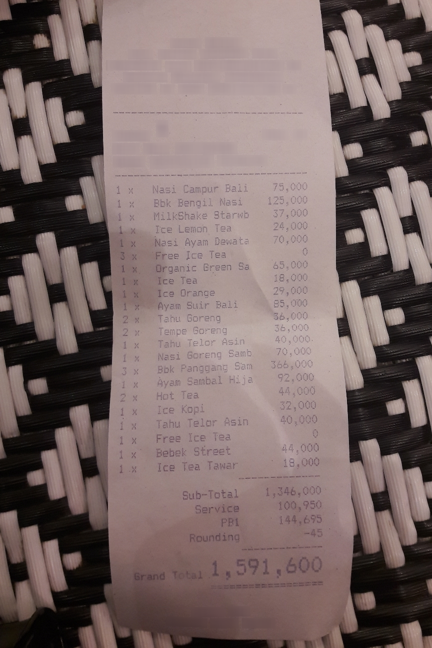

In [7]:
# example of an image from the dataset

example = train_data[0]
image = example['image']
width, height = image.size
display(image.resize((int(width*0.5), int(height*0.5))))

In [8]:
json_str = example['ground_truth']  
json = json.loads(json_str)  

In [9]:
json.keys()

dict_keys(['gt_parse', 'meta', 'valid_line', 'roi', 'repeating_symbol', 'dontcare'])

we are interested on valid_line , which has the information of post OCR and meta which has the image_id and image_size 

In [10]:
json['meta']

{'version': '2.0.0',
 'split': 'train',
 'image_id': 0,
 'image_size': {'width': 864, 'height': 1296}}

In [11]:
json['valid_line']

[{'words': [{'quad': {'x2': 244,
     'y3': 390,
     'x3': 244,
     'y4': 390,
     'x1': 232,
     'y1': 372,
     'x4': 232,
     'y2': 372},
    'is_key': 0,
    'row_id': 2179893,
    'text': '1'},
   {'quad': {'x2': 270,
     'y3': 390,
     'x3': 270,
     'y4': 390,
     'x1': 256,
     'y1': 374,
     'x4': 256,
     'y2': 374},
    'is_key': 0,
    'row_id': 2179893,
    'text': 'x'}],
  'category': 'menu.cnt',
  'group_id': 3,
  'sub_group_id': 0},
 {'words': [{'quad': {'x2': 354,
     'y3': 390,
     'x3': 354,
     'y4': 390,
     'x1': 302,
     'y1': 368,
     'x4': 302,
     'y2': 368},
    'is_key': 0,
    'row_id': 2179893,
    'text': 'Nasi'},
   {'quad': {'x2': 440,
     'y3': 391,
     'x3': 439,
     'y4': 388,
     'x1': 364,
     'y1': 365,
     'x4': 363,
     'y2': 368},
    'is_key': 0,
    'row_id': 2179893,
    'text': 'Campur'},
   {'quad': {'x2': 497,
     'y3': 385,
     'x3': 499,
     'y4': 388,
     'x1': 446,
     'y1': 365,
     'x4': 448,
     'y2

In our problem, we want to detect total TTC , i assumed that the total ttc gonna be total.total_price so i included the label 'O' (outside) for tokens that do not match the "total.total_price" label

So  each group of word in category is assigned a label. If the group of word belongs to the total.total_price category, it retains this label; otherwise, it is marked as 'O' (other).

In [12]:
labels = ['O', 'total.total_price']

Let's prepare our datasets so that they are compatible with the input of our model LayoutLMv3. The following code snippet will help us generate the necessary annotations for the training, validation, and test sets by processing each sample to extract image_ids, words, bounding boxes, and labels.

In [22]:

def normalize_bbox(bbox, width, height):

    """
    Normalizing the bounding box coordinates to a fixed scale (0 to 1000) based on the original width and height of the image.
    This is essential to ensure consistency across different images with varying sizes and resolutions.
    
    """
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

# this function was inspired by Niels Rogge data preparation for LayoutLMv3
def generate_annotations(dataset):
    image_ids = []
    words = []
    boxes = []
    labels = []

    for idx, js in enumerate(tqdm(dataset)):
        ground_truth = js['ground_truth']
        ground_truth = json.loads(ground_truth)
        
        words_example = []
        boxes_example = []
        labels_example = []

        width, height = ground_truth['meta']['image_size']['width'], ground_truth['meta']['image_size']['height']

        for elem in ground_truth['valid_line']:
            if len(elem['words']) > 0:
                # Creating the bounding box that covers all the words in the category
                x1 = elem['words'][0]['quad']['x1']
                y1 = elem['words'][0]['quad']['y1']
                x3 = elem['words'][-1]['quad']['x3']
                y3 = elem['words'][-1]['quad']['y3']
                
                text_concat = ' '.join([word['text'] for word in elem['words']])

                # box
                box = [x1, y1, x3, y3]
                box = normalize_bbox(box, width=width, height=height)

                # Skip empty text
                if len(text_concat.strip()) < 1:
                    continue
                if min(box) < 0 or max(box) > 1000:  # Avoid invalid boxes
                    continue
                if ((box[3] - box[1]) < 0) or ((box[2] - box[0]) < 0):  # Avoid negative box dimensions
                    continue

                words_example.append(text_concat)
                boxes_example.append(box)
                # Marking the label as 'O' if it's not 'total.total_price'
                label = elem['category'] if elem['category'] == 'total.total_price' else 'O'
                labels_example.append(label)

        words.append(words_example)
        boxes.append(boxes_example)
        labels.append(labels_example)
        image_ids.append(ground_truth['meta']['image_id'])

    return image_ids, words, boxes, labels


In [23]:
image_ids_train, words_train, boxes_train, labels_train = generate_annotations(train_data)
image_ids_val, words_val, boxes_val, labels_val = generate_annotations(validate_data)
image_ids_test, words_test, boxes_test, labels_test = generate_annotations(test_data)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

I upload in the Dataset folder the annotations after preparation

In [24]:
with open('Dataset/train.pkl', 'wb') as t:
    pickle.dump([image_ids_train, words_train, boxes_train, labels_train ], t)
with open('Dataset/val.pkl', 'wb') as t:
    pickle.dump([image_ids_val, words_val, boxes_val, labels_val], t)
with open('Dataset/test.pkl', 'wb') as t:
    pickle.dump([image_ids_test, words_test, boxes_test, labels_test], t)